Recurrent Neural Network (RNN) {-}

training, validating and testing Recurrent Neural Networks (RNNs). Here are 

- Load the data.
- Analyze the data.
- Process the data.
- Build a RNN model using GRU (https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU) instead of LSTM as in the demo code.
- Train and validate the RNN model (with GRU) to perform the movie review classification.
- Evaluate the performance of the model on the test set.
- Compare the accuracy and the running time between GRU and LSTM.
- Visualize the model behaviour during the training.

The dataset you will be working on is imdb_reviews. This dataset is a large movie review dataset. This dataset is for binary sentiment classification containing a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. All the reviews have either a positive or negative sentiment. Reference: http://ai.stanford.edu/~amaas/data/sentiment/

Each data sample contains:
- label (tf.int64)
- text (tf.string)

### Submission {-}
The structure of submission folder should be organized as follows:

- ./\<StudentID>-assignment3-notebook.ipynb: Jupyter notebook containing source code.

The submission folder is named DL4AI-\<StudentID>-Assignment3 (e.g., DL4AI-2012345-Assigment3) and then compressed with the same name.

### Evaluation {-}
Assignment evaluation will be conducted on how you accomplish the assignment requirements. The model accuracy on the test set is one of the most important evaluation criteria. Therefore tooiry to push it as high as possible. In addition, your code should conform to a Python coding convention such as PEP-8.

### Deadline {-}
Please visit Canvas for details.

In [1]:
# Note: to enable GPU training in Colab, go to Runtime > Change runtime type > Hardware acceleration > Choose GPU from the drop-down list.

# Download tensorflow datasets
!pip install tensorflow_datasets

# Import libraries
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import time

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Load the IMDB movie review dataset, return text (movie review) and label (positive/negative)
train_dataset, val_dataset, test_dataset = tfds.load(name="imdb_reviews", split=('train[:80%]', 'train[80%:]', 'test'), as_supervised=True)

print("Training set: ", len(train_dataset), "samples")
print("Validation set: ", len(val_dataset), "samples")
print("Test set: ", len(test_dataset), "samples")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteXAJYKY/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteXAJYKY/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteXAJYKY/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
Training set:  20000 samples
Validation set:  5000 samples
Test set:  25000 samples


In [3]:
# Show same samples in the training set
for example, label in train_dataset.take(3):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0
text:  b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. 

In [4]:
### Convert Tensorflow Dataset to numpy arrays of feature vector X and label y

# Convert training set
train_ds_numpy = tfds.as_numpy(train_dataset) # Convert TF Dataset to an iterable of numpy array
train_numpy = np.vstack(list(train_ds_numpy)) # Stack to full numpy array
X_train = np.array(list(map(lambda x: x[0], train_numpy))) # Extract review (index 0) from numpy vector
y_train = np.array(list(map(lambda x: x[1], train_numpy))).astype(np.int16) # Extract label (index 1) from numpy vector and convert grom string to number
print("X_train shape: " + str(X_train.shape))
print("y_train shape: " + str(y_train.shape))

# Convert validation set
val_ds_numpy = tfds.as_numpy(val_dataset) # Convert TF Dataset to an iterable of numpy array
val_numpy = np.vstack(list(val_ds_numpy)) # Stack to full numpy array
X_val = np.array(list(map(lambda x: x[0], val_numpy))) # Extract review (index 0) from numpy vector
y_val = np.array(list(map(lambda x: x[1], val_numpy))).astype(np.int16) # Extract label (index 1) from numpy vector
print("X_val shape: " + str(X_val.shape))
print("y_val shape: " + str(y_val.shape))

# Convert test set
test_ds_numpy = tfds.as_numpy(test_dataset) # Convert TF Dataset to an iterable of numpy array
test_numpy = np.vstack(list(test_ds_numpy)) # Stack to full numpy array
X_test = np.array(list(map(lambda x: x[0], test_numpy))) # Extract review (index 0) from numpy vector
y_test = np.array(list(map(lambda x: x[1], test_numpy))).astype(np.int16) # Extract label (index 1) from numpy vector
print("X_test shape: " + str(X_test.shape))
print("y_test shape: " + str(y_test.shape))

X_train shape: (20000,)
y_train shape: (20000,)
X_val shape: (5000,)
y_val shape: (5000,)
X_test shape: (25000,)
y_test shape: (25000,)


# Encode the text
### Initialize and build the text vectorizer

In [5]:
### TextVectorization layer maps text features to integer sequences.
# Set vocabulary size for the training data
VOCAB_SIZE = 1000

# Initialize the TextVectorization layer for raw text encoding
text_encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE) # Maximum size of the vocabulary

# Feed training text to adapt() method to calculate the layer's vocabulary 
text_encoder.adapt(X_train)

In [6]:
# Show the first 20 tokens. After the padding ('') and unknown ([UNK]) tokens they're sorted by frequency.
vocab = np.array(text_encoder.get_vocabulary()) # Get the vocabulary of the training set after the adaptation
print("Vocabulary size:", vocab.shape)
vocab[:20] # Show the first 20 tokens (sorted by frequency) in the vocabulary

Vocabulary size: (1000,)


array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

### Test the text vectorizer

### Example of how a text vectorization layer works. It maps strings to integers.

# Create the model that uses the text vectorization layer
model_encoder = tf.keras.models.Sequential()

# Creating an explicit input layer.
# It needs to have a shape of (1,) (because we need to guarantee that there is exactly one string input per batch),
model_encoder.add(tf.keras.Input(shape=(1,), dtype=tf.string))

# The first (unique) layer in the model is the vectorization layer.
# After this layer, we have a tensor of shape (batch_size, max_len) containing vocab indices.
model_encoder.add(text_encoder)

# The model can map strings to integers, and you can add an embedding layer to map these integers to learned embeddings.
test_data = [["I want to drink"], ["I do not want to eat but I want to sleep"]]
model_encoder.predict(test_data)

# Note: The tensors of indices are zero-padded to the longest sequence in the batch,
# to make sure that all tensors of indices have the same size (for batching purpose).

### Text vectorization is not completely reversible

In [7]:
# Note: the vectorization process is not completely reversible due to the limited vocabulary size
print("Original: ", X_train[0])
print()
print("Round-trip: ", " ".join(vocab[text_encoder(X_train[0]).numpy()]))

Original:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."

Round-trip:  this was an absolutely terrible movie dont be [UNK] in by [UNK] [UNK] or michael [UNK] both are great actors but this must simply be their worst role in history even their great acting could not [UNK] this movies ridiculous storyline this movie is an early [UNK]

## Build the model using LSTM and GRU layers

In [8]:
# Initialize a sequential model since all the layers in the model only have single input and produce single output
# define LSTM model
lstm_model = tf.keras.Sequential([
    text_encoder, # Text encoder layer, i.e., TextVectorization layer
    tf.keras.layers.Embedding( # Text embedding layer, i.e., turns positive integers (indexes) into dense vectors of fixed size.
        input_dim=len(text_encoder.get_vocabulary()), # Get the size of word vocabulary (positive integers), VOCAB_SIZE.
        output_dim=64, # Fixed size of the output embedding vectors which is fed as input of LSTM layer.
        mask_zero=True), # Whether or not the input value 0 (the zero-padding) should be masked out
        # Hence if mask_zero = True, index 0 cannot be used in the vocabulary (input_dim = vocabulary size + 1)
    tf.keras.layers.LSTM(units=64), # Output dimension of LSTM layer
    tf.keras.layers.Dense(64, activation='relu'), # Dense layer
    tf.keras.layers.Dense(1, activation='sigmoid') # Classification output
])

# Summarize the model
lstm_model.summary()

# Calculate the number of parameters of each layer
# Embedding = input_dim * output_dim = 1,000*64 = 64,000
# LSTM = 4*(input_dim * output_dim + output_dim + output_dim^2) = 4*(64*64+64+64^2) = 33,024
# dense = (input_dim + 1) * output_dim = (64 + 1) * 64 = 4,160

# The embedding layer uses masking to handle the varying sequence-lengths

# Check if the layers after the Embedding supports masking
print([layer.supports_masking for layer in lstm_model.layers])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          64000     
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 101,249
Trainable params: 101,249
Non-trainable params: 0
__________________________________________________

In [9]:
# define GRU model
gru_model = tf.keras.Sequential([
    text_encoder, # Text encoder layer, i.e., TextVectorization layer
    tf.keras.layers.Embedding( # Text embedding layer, i.e., turns positive integers (indexes) into dense vectors of fixed size.
        input_dim=len(text_encoder.get_vocabulary()), # Get the size of word vocabulary (positive integers), VOCAB_SIZE.
        output_dim=64, # Fixed size of the output embedding vectors which is fed as input of GRU layer.
        mask_zero=True), # Whether or not the input value 0 (the zero-padding) should be masked out
        # Hence if mask_zero = True, index 0 cannot be used in the vocabulary (input_dim = vocabulary size + 1)
    tf.keras.layers.GRU(units=64), # Output dimension of GRU layer
    tf.keras.layers.Dense(64, activation='relu'), # Dense layer
    tf.keras.layers.Dense(1, activation='sigmoid') # Classification output
])

# Summarize the model
gru_model.summary()

# Calculate the number of parameters of each layer
# Embedding = input_dim * output_dim = 1,000*64 = 64,000
# GRU = 3*(input_dim * output_dim + output_dim + output_dim^2) = 3*(64*64+64+64^2) = 24,576
# dense = (input_dim + 1) * output_dim = (64 + 1) * 64 = 4,160

# The embedding layer uses masking to handle the varying sequence-lengths
# Check if the layers after the Embedding supports masking
print([layer.supports_masking for layer in gru_model.layers])


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, None, 64)          64000     
                                                                 
 gru (GRU)                   (None, 64)                24960     
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 93,185
Trainable params: 93,185
Non-trainable params: 0
__________________________________________________

In [10]:
# Compile the models
lstm_model.compile(loss='binary_crossentropy', # Binary classification loss
              optimizer=tf.keras.optimizers.Adam(1e-3), # Optimizer
              metrics=['accuracy']) # Evaluation metric

gru_model.compile(loss='binary_crossentropy', # Binary classification loss
              optimizer=tf.keras.optimizers.Adam(1e-3), # Optimizer
              metrics=['accuracy']) # Evaluation metric


### Train and measure the running time of the lstm_model and gru_model

In [11]:
# Train the LSTM model
start_time = time.time()
lstm_history = lstm_model.fit(X_train, y_train, epochs=10, batch_size = 2048, validation_data=(X_val, y_val)) # Here the test dataset is used as validtion set
lstm_training_time = time.time() - start_time


Epoch 1/10
10/10 [==============================] - 15s 511ms/step - loss: 0.6924 - accuracy: 0.5358 - val_loss: 0.6903 - val_accuracy: 0.6180
Epoch 2/10
10/10 [==============================] - 3s 324ms/step - loss: 0.6838 - accuracy: 0.6298 - val_loss: 0.6649 - val_accuracy: 0.6900
Epoch 3/10
10/10 [==============================] - 3s 353ms/step - loss: 0.6059 - accuracy: 0.7133 - val_loss: 0.5635 - val_accuracy: 0.7728
Epoch 4/10
10/10 [==============================] - 3s 325ms/step - loss: 0.5028 - accuracy: 0.7832 - val_loss: 0.4544 - val_accuracy: 0.8160
Epoch 5/10
10/10 [==============================] - 3s 327ms/step - loss: 0.4270 - accuracy: 0.8206 - val_loss: 0.4010 - val_accuracy: 0.8294
Epoch 6/10
10/10 [==============================] - 3s 351ms/step - loss: 0.3779 - accuracy: 0.8416 - val_loss: 0.3656 - val_accuracy: 0.8442
Epoch 7/10
10/10 [==============================] - 3s 299ms/step - loss: 0.3514 - accuracy: 0.8526 - val_loss: 0.3676 - val_accuracy: 0.8428
Epoch

In [12]:
# Train the GRU model
start_time = time.time()
gru_history = gru_model.fit(X_train, y_train, epochs=10, batch_size = 2048, validation_data=(X_val, y_val)) # Here the test dataset is used as validtion set
gru_training_time = time.time() - start_time


Epoch 1/10
10/10 [==============================] - 11s 485ms/step - loss: 0.6921 - accuracy: 0.5348 - val_loss: 0.6904 - val_accuracy: 0.5680
Epoch 2/10
10/10 [==============================] - 3s 314ms/step - loss: 0.6847 - accuracy: 0.6003 - val_loss: 0.6787 - val_accuracy: 0.6004
Epoch 3/10
10/10 [==============================] - 3s 322ms/step - loss: 0.6587 - accuracy: 0.6380 - val_loss: 0.6362 - val_accuracy: 0.6458
Epoch 4/10
10/10 [==============================] - 3s 342ms/step - loss: 0.5752 - accuracy: 0.7093 - val_loss: 0.5304 - val_accuracy: 0.7266
Epoch 5/10
10/10 [==============================] - 3s 304ms/step - loss: 0.4993 - accuracy: 0.7571 - val_loss: 0.4758 - val_accuracy: 0.7674
Epoch 6/10
10/10 [==============================] - 3s 320ms/step - loss: 0.4237 - accuracy: 0.8108 - val_loss: 0.4008 - val_accuracy: 0.8206
Epoch 7/10
10/10 [==============================] - 3s 324ms/step - loss: 0.3687 - accuracy: 0.8397 - val_loss: 0.3634 - val_accuracy: 0.8398
Epoch

In [13]:
# Evaluate the lstm  model on the test set
start_time = time.time()
lstm_test_loss, lstm_test_acc = lstm_model.evaluate(X_test, y_test)
lstm_evaluation_time = time.time() - start_time

# Evaluate the  gru model on the test set
start_time = time.time()
gru_test_loss, gru_test_acc = gru_model.evaluate(X_test, y_test)
gru_evaluation_time = time.time() - start_time


782/782 [==============================] - 10s 13ms/step - loss: 0.3371 - accuracy: 0.8576


In [14]:
# Print results of Comparison of  the  accuracy and the running time between GRU and LSTM.
print("LSTM Model:")
print('lstm_test Loss:', lstm_test_loss)
print('lstm_test Accuracy:', lstm_test_acc)
print("Training Time: {:.2f} seconds".format(lstm_training_time))
print("Evaluation Time: {:.2f} seconds".format(lstm_evaluation_time))

print("\nGRU Model:")
print('gru_test Loss:', gru_test_loss)
print('gru_test Accuracy:', gru_test_acc)
print("Training Time: {:.2f} seconds".format(gru_training_time))
print("Evaluation Time: {:.2f} seconds".format(gru_evaluation_time))

LSTM Model:
lstm_test Loss: 0.33686530590057373
lstm_test Accuracy: 0.8560400009155273
Training Time: 85.78 seconds
Evaluation Time: 20.70 seconds

GRU Model:
gru_test Loss: 0.3370971977710724
gru_test Accuracy: 0.8575999736785889
Training Time: 39.10 seconds
Evaluation Time: 20.71 seconds


based-on the run time we can see that with the same hyper-parameter, the accuracy of both models are closed to each other, 0.8560400009155273 for LSTM Model and 0.8575999736785889 for GRU Model. but the running time for trainning the LSTM model is much more expensive than GRU model, 85.78 in comparison with 39.10. so we can use GRU model for better performance in this case.


- Visualize the GRU model behaviour during the training.


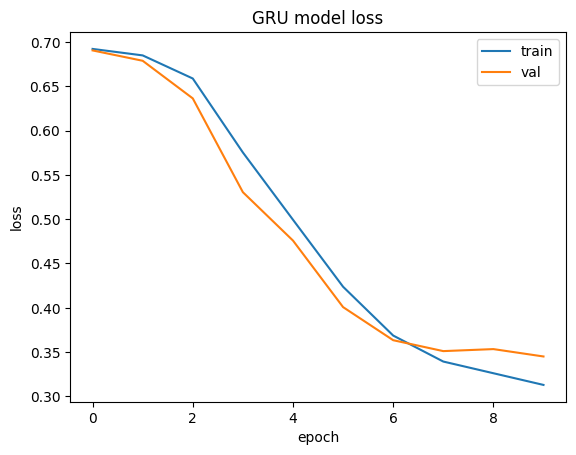

In [15]:
# Visualize the training and validation loss of GRU model over epochs
plt.plot(gru_history.history['loss'])
plt.plot(gru_history.history['val_loss'])
plt.title('GRU model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

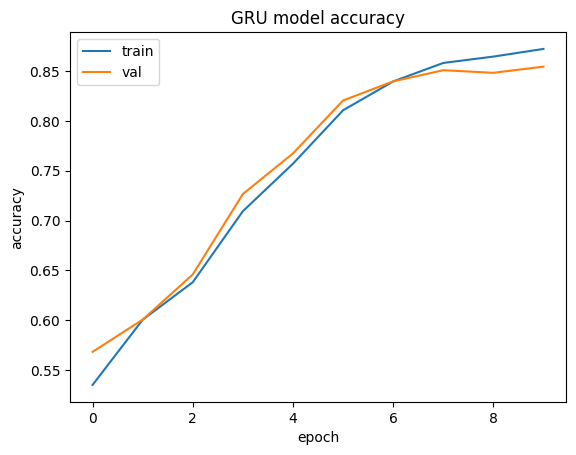

In [16]:
# Visualize the training and validation accuracy of GRU model over epochs
plt.plot(gru_history.history['accuracy'])
plt.plot(gru_history.history['val_accuracy'])
plt.title('GRU model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [17]:
# Make prediction on a new data sample
sample_reviews = [('It is a cool movie. The graphics and the animation are awesome.'),
                  ('The movie was really bad. I would not recommend it to anyone.')]
predictions = gru_model.predict(np.array(sample_reviews))
print(predictions[0])
print(predictions[1])

1/1 [==============================] - 1s 1s/step
[0.73045087]
[0.28266865]
